In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
#from torchview import draw_graph
import matplotlib.pyplot as plt
import numpy as np
import time
from auxiliary.visualization import plot_raster
from auxiliary.evaluation import calculate_conf_matrix, calculate_metrics
from model_components.unet import *
from model_components.resunet import *
from model_components.attunet import *

In [2]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Device set to: {device}")

Device set to: mps


In [3]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [4]:
# Define DIN font for plots
plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [5]:
# Setting up a Dataset object for DataLoader
class BuildingRasterDataset(Dataset):
    def __init__(self, path, n_channels=3, transform=None):
        '''Stores the directory and filenames of the individual .npz files.'''
        assert n_channels in (2, 3)
        
        # store directory of individual files
        self.path = path
        # get filenames of individual files
        self.filenames = os.listdir(path)

        # store the number of channels of the returned image
        self.n_channels = n_channels

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation.'''
        return len(self.filenames)

    def __getitem__(self, index):
        '''Enables indexing, returns uuid and block raster as features and generalization operators as label.'''
        # get filename associated with given index
        filename = self.filenames[index]

        # load the file with the filename
        sample = np.load(os.path.join(self.path, filename))

        # extract the rasters
        target = sample["target"]
        context = sample["context"]
        road = sample["road"]

        # stack the rasters according to n_channels
        if self.n_channels == 3:
            # stack the rasters to shape (3, n_pixels, n_pixels)
            block = np.stack([target, context, road], axis=0)
        elif self.n_channels == 2:
            # combine context and road
            context_road = context + road
            # correct overlapping features
            context_road[context_road > 1.0] = 1.0

            # stack the rasters to shape (2, n_pixels, n_pixels)
            block = np.stack([target, context_road], axis=0)

        # convert rasters to tensor
        block = torch.from_numpy(block).float()

        # extract generalization operators and convert to tensors
        eli = torch.from_numpy(sample["elimination"]).float()
        agg = torch.from_numpy(sample["aggregation"]).float()
        typ = torch.from_numpy(sample["typification"]).float()
        dis = torch.from_numpy(sample["displacement"]).float()
        enl = torch.from_numpy(sample["enlargement"]).float()
        sim = torch.from_numpy(sample["simplification"]).float()

        if self.transform:
            block = self.transform(block)

        return block, eli, agg, typ, dis, enl, sim

### Training pipeline

1) Design model (input, output size, forward pass)
2) Construct loss and optimizer
3) Training loop
     * Forward pass: Compute prediction
     * Backward pass: Compute gradients
     * Update weights

### Model design

Stride refers to the number of positions that the convolutional kernel shifts at one step. Input channel size of one layer should always be equal to the output channel size of the previous layer.

The application of convolution and pooling layers decreases the size of the image: The output after a convolution can be calculated according to the following formula, where $W$ is the input width, $F$ is the kernel size, $P$ is the padding and $S$ is the stride:

$$\frac{(W-F + 2 P)}{S} + 1$$

In [6]:
# Fully-connected layers with Global Average Pooling
class FCGlobalPooling(nn.Module):
    def __init__(self, n_last_out_channels):
        super(FCGlobalPooling, self).__init__()
        self.n_last_out_channels = n_last_out_channels
        
        # Due to the global average pooling, the number of input features corresponds to the number of output channels of the last
        # convolutional layers
        # the last fully-connected layer has six output neurons, one for each generalization operator
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(), # flatten to reshape the tensor from 4D to 2D
            nn.Linear(in_features=self.n_last_out_channels, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=6)
        )

    def forward(self, x):
        return self.fc(x)

# Fully-connected layers without Global Average Pooling
class FC(nn.Module):
    def __init__(self, n_last_out_channels, image_size):
        super(FC, self).__init__()
        self.n_last_out_channels = n_last_out_channels
        self.image_size = image_size
        
        # the number of input features of first fully-connected layer are calculated by multiplying number of output channels of last 
        # convolutional layer by (image size after all pooling operations)^2
        # the last fully-connected layer has six output neurons, one for each generalization operator
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.n_last_out_channels*self.image_size*self.image_size, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=6)
        )

    def forward(self, x):
        return self.fc(x)

In [7]:
# https://amaarora.github.io/posts/2020-09-13-unet.html

# conventional, simple CNN
class CNN(nn.Module):
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # appending fully-connected layers
        #self.fc = FCGlobalPooling(n_last_out_channels=128)
        self.fc = FC(n_last_out_channels=128, image_size=32)

    def forward(self, x):
        # input dimension = 256
        x = self.pool(F.relu(self.conv1(x)))
        # input dimension = 128
        x = self.pool(F.relu(self.conv2(x)))
        # input dimension = 64
        x = self.pool(F.relu(self.conv3(x)))
        # input dimension = 32
        x = self.fc(x) # No sigmoid function necessary, since BCEWithLogitsLoss applies sigmoid internally for loss computation

        return x

# Code for U-net adapted from https://github.com/milesial/Pytorch-UNet
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 1))

        # appending fully-connected layers
        self.fc = FCGlobalPooling(n_last_out_channels=1)
        #self.fc = FC(n_last_out_channels=1, image_size=256)

    def forward(self, x):
        # encoding
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # decoding + concatenation
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        # passing the segmentation output through fully-connected layers for classification
        x = self.fc(logits)

        return x

# Code for Residual U-net adapted from https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture
class ResUNet(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        #self.sigmoid = nn.Sigmoid() # sigmoid not necessary when using BCEWithLogitsLoss

        # appending fully-connected layers
        self.fc = FCGlobalPooling(n_last_out_channels=1)
        #self.fc = FC(n_last_out_channels=1, image_size=256)

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        #output = self.sigmoid(output) # sigmoid not necessary when using BCEWithLogitsLoss

        # passing the segmentation output through fully-connected layers for classification
        output = self.fc(output)

        return output

# Code for Attention U-net adapted from https://github.com/LeeJunHyun/Image_Segmentation
class AttUNet(nn.Module):
    def __init__(self,n_channels):
        super(AttUNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=n_channels,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)

        # appending fully-connected layers
        self.fc = FCGlobalPooling(n_last_out_channels=1)
        #self.fc = FC(n_last_out_channels=1, image_size=256)

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        # passing the segmentation output through fully-connected layers for classification        
        output = self.fc(d1)

        return output

n_channels = 3

# Creating model and moving to device
#model = CNN(n_channels=n_channels)
#model = UNet(n_channels=n_channels)
#model = ResUNet(n_channels=n_channels)
model = AttUNet(n_channels=n_channels)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {total_params:,}")
model.to(device)

Number of parameters in the model: 34,882,675


AttUNet(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
   

In [8]:
learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Loss and activation function

Softmax is a common activation function, (binary) cross-Entropy is a common loss function for multiclass classification problems, sigmoid is commonly used for binary classification problems. When using the Pytorch implementation: no softmax in the last layer, class labels not one-hot encoded and no softmax. BCELoss requires an activation function at the end! Sigmoid are usually the last layers in binary classification probems.

If you don't know which activation function to use, just use ReLU, Leaky ReLU tries to adress vanishing gradient problem. Multiplies input with small negative numbers, as normal ReLU may cause many gradients to become zero, which means that the weights will never be updated. Whenever weights are not updated during training, use Leaky ReLU.

I am dealing with a multilabel (for each generalization operator), binary (operator present or absent) classification problem.

### Training loop

In [9]:
# if CUDA is available, use the cluster path, else local path
if torch.cuda.is_available():
    path_to_data = "../scratch/raster"
else:
    path_to_data = "../data.nosync/raster"

# number of epochs and batch size
num_epochs = 10
batch_size = 1

# composing various random transforms that should be applied to the data
transform = transforms.Compose(
    [transforms.RandomRotation(degrees=(0,360)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)])

# construct DataLoader
train_dataset = BuildingRasterDataset(path_to_data, n_channels=n_channels, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

print(f"{len(train_dataset):,} samples in the dataset.")

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
train_losses = []

start_time = time.perf_counter()
    
for epoch in range(num_epochs):
    # tracking loss per epoch
    train_running_loss = 0.0
    n_batches = 0
    for i, (block, eli, agg, typ, dis, enl, sim) in enumerate(train_dataloader): 
        n_batches += 1
        # moving the features to device
        block = block.to(device)
        eli = eli.to(device)
        agg = agg.to(device)
        typ = typ.to(device)
        dis = dis.to(device)
        enl = enl.to(device)
        sim = sim.to(device)
    
        # concatenate the operators: The first output neuron will indicate presence or absence of elimination, the second aggregation...
        operators = torch.stack([eli, agg, typ, dis, enl, sim], dim=1).float()
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators, operators) # calculate loss
        train_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}")
    
    # print information at the end of each epoch
    train_loss_epoch = train_running_loss / n_batches
    train_losses.append(train_loss_epoch)
    print(f"epoch {epoch+1} finished, loss: {train_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:.3f} seconds")

10 samples in the dataset.
epoch 1/10, step 1/10
epoch 1/10, step 2/10
epoch 1/10, step 3/10
epoch 1/10, step 4/10
epoch 1/10, step 5/10
epoch 1/10, step 6/10
epoch 1/10, step 7/10
epoch 1/10, step 8/10
epoch 1/10, step 9/10
epoch 1/10, step 10/10
epoch 1 finished, loss: 0.623
epoch 2/10, step 1/10
epoch 2/10, step 2/10
epoch 2/10, step 3/10
epoch 2/10, step 4/10
epoch 2/10, step 5/10
epoch 2/10, step 6/10
epoch 2/10, step 7/10
epoch 2/10, step 8/10
epoch 2/10, step 9/10
epoch 2/10, step 10/10
epoch 2 finished, loss: 0.481
epoch 3/10, step 1/10
epoch 3/10, step 2/10
epoch 3/10, step 3/10
epoch 3/10, step 4/10
epoch 3/10, step 5/10
epoch 3/10, step 6/10
epoch 3/10, step 7/10
epoch 3/10, step 8/10
epoch 3/10, step 9/10
epoch 3/10, step 10/10
epoch 3 finished, loss: 0.452
epoch 4/10, step 1/10
epoch 4/10, step 2/10
epoch 4/10, step 3/10
epoch 4/10, step 4/10
epoch 4/10, step 5/10
epoch 4/10, step 6/10
epoch 4/10, step 7/10
epoch 4/10, step 8/10
epoch 4/10, step 9/10
epoch 4/10, step 10/10

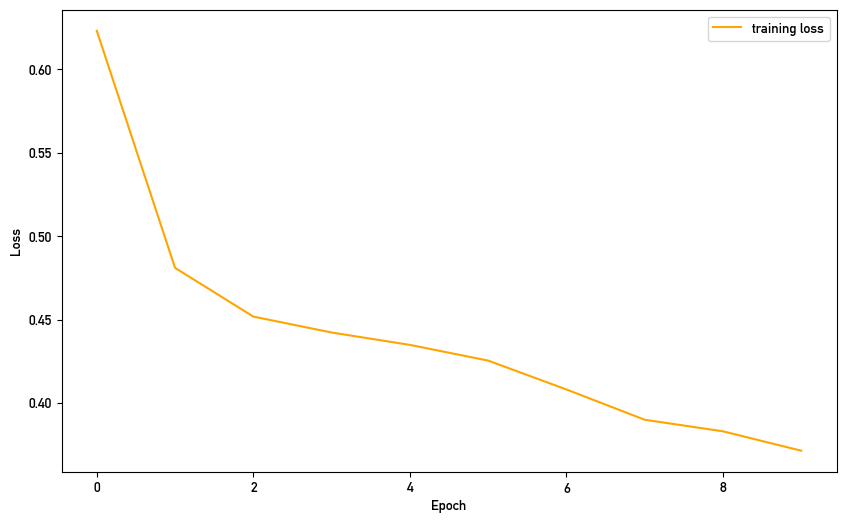

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, color="orange", label="training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation and metrics

In [11]:
test_dataset = BuildingRasterDataset(path_to_data, n_channels=n_channels)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# stores the confusion matrices for every operator
metrics = {}

for operator_name in operator_order:
    metrics[operator_name] = {}
    metrics[operator_name]["tp"] = 0
    metrics[operator_name]["fp"] = 0
    metrics[operator_name]["tn"] = 0
    metrics[operator_name]["fn"] = 0

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, eli, agg, typ, dis, enl, sim in test_dataloader:
        # moving the features to device
        block = block.to(device)
        eli = eli.to(device)
        agg = agg.to(device)
        typ = typ.to(device)
        dis = dis.to(device)
        enl = enl.to(device)
        sim = sim.to(device)

        # concatenate the operators: The first output neuron will indicate presence or absence of elimination, the second aggregation...
        operators = torch.stack([eli, agg, typ, dis, enl, sim], dim=1).float()

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators = torch.sigmoid(model(block))
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # calculating metrics for the individual operators
        for i, operator_name in enumerate(operator_order):
            operator = operators[:, i]
            pred_operator = pred_operators_labels[:, i]

            tp, fp, tn, fn = calculate_conf_matrix(operator, pred_operator)

            metrics[operator_name]["tp"] += tp
            metrics[operator_name]["fp"] += fp
            metrics[operator_name]["tn"] += tn
            metrics[operator_name]["fn"] += fn

for operator_name in operator_order:
    accuracy, precision, recall, f1_score = calculate_metrics(metrics[operator_name]["tp"],
                                                              metrics[operator_name]["fp"],
                                                              metrics[operator_name]["tn"],
                                                              metrics[operator_name]["fn"])
    
    print(f"{operator_name.upper()}: Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1_score:.3f}")

ELIMINATION: Accuracy: 0.900, Precision: 0.000, Recall: 0.000, F1-score: 0.000
AGGREGATION: Accuracy: 0.700, Precision: 0.600, Recall: 0.750, F1-score: 0.667
TYPIFICATION: Accuracy: 0.900, Precision: 0.000, Recall: 0.000, F1-score: 0.000
DISPLACEMENT: Accuracy: 0.800, Precision: 0.800, Recall: 1.000, F1-score: 0.889
ENLARGEMENT: Accuracy: 0.800, Precision: 0.800, Recall: 1.000, F1-score: 0.889
SIMPLIFICATION: Accuracy: 0.900, Precision: 0.000, Recall: 0.000, F1-score: 0.000


### Saving the model

https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/

### Ideas

* Investigate effect of building size on the prediction quality? Other "confounding" factors.
* See whether including the roads actually increases the prediction performance.
* Investigate effects of imbalanced data / operator distribution.